In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import OrderedDict
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [2]:
cmap = "YlGnBu"
cmap_r = "YlGnBu_r"
palette = sns.color_palette(cmap)
palette_r = sns.color_palette(cmap_r)

In [3]:
def statistical_analysis(data,q=[0.1,0.25,0.3,0.4,0.5,0.6,0.75,0.9]):
    
    mean = data.mean()
    var = data.var()
    std = data.std()
    
    stts = {'Среднее': mean, 'Дисперсия': var, 'Стандартное отклонение': std}
    stts = pd.DataFrame.from_dict(stts, orient='index', columns=['Значение'])
    
    quart_dict = {
                  0.1:  'D1(1-й дециль)',
                  0.2:  'D2(2-й дециль)',    
                  0.3:  'D3(3-й дециль)',
                  0.4:  'D4(4-й дециль)',
                  0.6:  'D6(6-й дециль)',
                  0.7:  'D7(7-й дециль)',
                  0.8:  'D8(8-й дециль)',
                  0.9:  'D9(9-й дециль)',
                  0.25: 'Q1(1-й квартиль)',
                  0.5:  'Q2=Med(2-й квартиль, медиана)',
                  0.75: 'Q3(3-й квартиль)',
                 }
    
    for i in q:
        if i not in quart_dict.keys():
            n = str(i).split('.')[1]
            quart_dict[i] = f"Q{n}({n}-й процентиль)"
    quart_dict = OrderedDict(sorted(quart_dict.items(), key=lambda t: t[0]))
        
    quarts = {}
    for key, value in quart_dict.items():
        quarts[value] = np.quantile(data,key)
    
    quarts = pd.DataFrame.from_dict(quarts, orient='index', columns=['Значение'])
    
    res = pd.concat([stts, quarts])
    
    plt.figure(figsize=(12,8))
    sns.histplot(data, stat="density")
    
    return res

In [4]:
def show_hist(data, x, hue, palette=cmap, title='Распределение клиентов по сумме покупки (руб)'):
    sns.set(rc={'figure.figsize':(12,8)})
    ax = sns.histplot(data=data, x=x, hue=hue, bins=40, palette=palette)
    
    #plt.title(title, fontsize=16)
    ax.set(xlabel=None, ylabel=None)
    plt.xticks(np.arange(0, 10500, step=500), fontsize=10, horizontalalignment='center')
        
    plt.show()

In [5]:
def show_heatmap(data, title, fmt='.2g'):
    f, ax = plt.subplots(figsize=(24, 10))

    sns.heatmap(data, 
                annot=True,
                cmap=cmap,
                fmt=fmt,
                annot_kws={'size':16}) # размер шрифта в ячейках

    plt.title(title, fontsize=16)  
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16, rotation=0)
    
    #ax.xaxis.set_ticks_position('bottom')
    #ax.xaxis.set_label_position('bottom') 

    #plt.xlabel("Сумма покупки (руб)")
    plt.xlabel("")
    #plt.ylabel("Длительность регистрации (мес)")
    plt.ylabel("")

    plt.show()

In [6]:
def ttest_func(a, b, alpha=0.05):
    statistic, pvalue = stats.ttest_ind(a, b)
    if pvalue > alpha:
        print('Принимается нулевая гипотеза')
    else:
        print('Принимается альтернативная гипотеза')
    print(f'стат. критерий: {statistic}, pvalue: {pvalue}')
    return statistic, pvalue

In [7]:
def mann_whitney_func(a, b, alpha=0.05):
    statistic, pvalue = stats.mannwhitneyu(a, b, alternative = 'two-sided')
    if pvalue > alpha:
        print('Распределения равны')
    else:
        print('Распределения не равны')
    print(f'стат. критерий: {statistic}, pvalue: {pvalue}')
    return statistic, pvalue

In [8]:
def bootstrap_func(a, b, color=palette[0]):
    boot = bs.bootstrap_ab(test = a, 
                       ctrl = b,
                       stat_func = bs_stats.mean,
                       compare_func = bs_compare.difference,
                       return_distribution=True)
    print(f'Bootstrap средняя разница среднего чека: {boot.mean()}')
    
    borders = np.percentile(boot, [2.5, 97.5])
    
    ax = sns.histplot(boot, color=palette[3])
    ax.set(xlabel=None, ylabel=None)
    
    plt.title('Bootstrap-распределение разниц среднего чека', fontsize=16)
    plt.rcParams["figure.figsize"] = (12, 6)
    
    plt.axvline(0,
               ymin=0, 
               ymax=0.5, 
               linestyle='--', 
               color=color)
    
    plt.axvline(borders[0],
               ymin=0, 
               ymax=0.5, 
               linestyle='--', 
               color='grey', 
               label='95%-доверительный интервал')
    
    plt.axvline(borders[1],
               ymin=0, 
               ymax=0.5, 
               linestyle='--', 
               color='grey')
    
    plt.legend()
    
    plt.show()

In [9]:
def eval_corr_result(corr, pvalue, alpha):
    corr = abs(corr)
    if pvalue > alpha:
        print('равна нулю')
    elif corr < 0.3:
        print('слабая')
    elif corr <= 0.7:
        print('средняя')
    else:
        print('сильная')

def proxi_ranges(a, b, alpha=0.05):
    mtx = np.cov(a, b)
    var_a = mtx[0][0]
    var_b = mtx[1][1]
    covar = mtx[0][1]
    covar_dict = {'Дисперсия 1-го ряда': var_a, 'Дисперсия 2-го ряда': var_b, 'Ковариация': covar}
    for key, value in covar_dict.items():
            print(f'{key}: {value}')

    corr_pearson, pvalue_pearson = stats.pearsonr(a, b)
    print(f'Корреляция Пирсона:', end=' ')
    eval_corr_result(corr=corr_pearson, pvalue=pvalue_pearson, alpha=alpha)
    print(corr_pearson)

    corr_spearman, pvalue_spearman = stats.spearmanr(a, b)
    print(f'Корреляция Спирмена:', end=' ')
    eval_corr_result(corr=corr_spearman, pvalue=pvalue_spearman, alpha=alpha)
    print(corr_spearman)

In [10]:
# читаем исходные данные
df = pd.read_csv('Dataset_AB_TEST.csv', sep=';')

# убираем пустые значения
df = df.dropna()

# меняем тип данных id_point
df = df.astype({'id_point':'int'})

In [11]:
df.head()

,id_client,id_group,sum_pay,id_point,months_reg
0,1420218,test,3288.0,1199,8
1,1390221,control,1267.0,1182,11
2,1363404,control,4259.0,1178,2
3,1370042,test,7211.0,1179,3
4,1360376,control,760.0,1178,14


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10840 entries, 0 to 10975
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_client   10840 non-null  int64  
 1   id_group    10840 non-null  object 
 2   sum_pay     10840 non-null  float64
 3   id_point    10840 non-null  int32  
 4   months_reg  10840 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(1)
memory usage: 465.8+ KB


In [13]:
df.describe()

,id_client,sum_pay,id_point,months_reg
count,1.084000e+04,10840.000000,10840.000000,10840.000000
mean,1.372953e+06,3568.758026,1180.039760,4.693911
std,1.482036e+04,2927.273978,4.353995,3.174513
min,1.359000e+06,59.000000,1178.000000,0.000000
25%,1.361710e+06,1250.750000,1178.000000,2.000000
50%,1.370636e+06,3173.500000,1179.000000,4.000000
75%,1.373417e+06,5356.500000,1179.000000,6.000000
max,1.420345e+06,24797.000000,1199.000000,14.000000


,Значение
Среднее,3.568758e+03
Дисперсия,8.568933e+06
Стандартное отклонение,2.927274e+03
D1(1-й дециль),4.100000e+02
D2(2-й дециль),8.728000e+02
Q1(1-й квартиль),1.250750e+03
D3(3-й дециль),1.590000e+03
D4(4-й дециль),2.329600e+03
"Q2=Med(2-й квартиль, медиана)",3.173500e+03
D6(6-й дециль),3.934000e+03


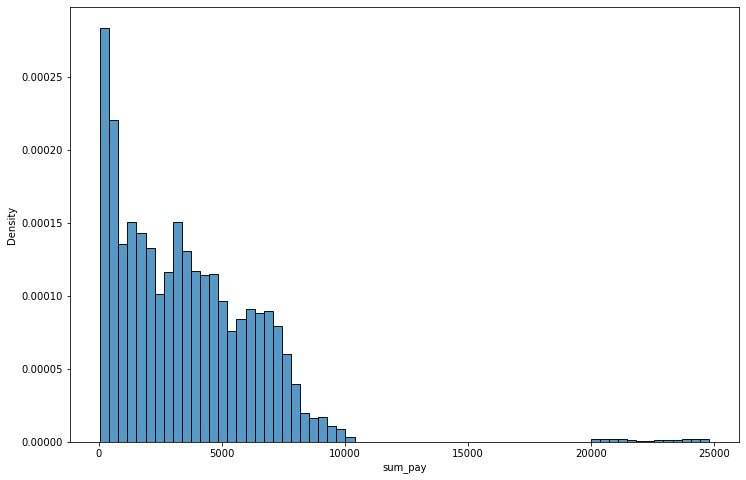

In [14]:
statistical_analysis(df['sum_pay'])

In [15]:
# убираем выбросы
df = df[df['sum_pay'] < 15000]

In [16]:
# убираем точку 1199, у которой нет контрольной группы, только тестовая
df = df[df['id_point'] != 1199]

### Общий анализ AB теста

In [17]:
test = df[df['id_group'] == 'test']['sum_pay'].values
control = df[df['id_group'] == 'control']['sum_pay'].values

In [18]:
len(test)

5145

In [19]:
len(control)

5140

In [20]:
test.mean()

3478.955879494655

In [21]:
control.mean()

3339.535408560311

In [22]:
test.mean() - control.mean()

139.42047093434394

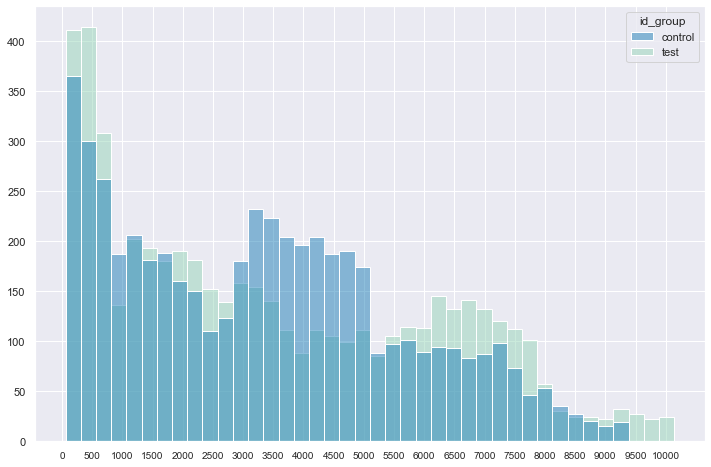

In [23]:
show_hist(data=df,
          x=df['sum_pay'],
          hue="id_group",
          palette=cmap_r)

In [24]:
ttest_func(test, control)

Принимается альтернативная гипотеза
стат. критерий: 2.8537908222421335, pvalue: 0.0043287276989780535


(2.8537908222421335, 0.0043287276989780535)

In [25]:
mann_whitney_func(test, control)

Распределения равны
стат. критерий: 13307632.5, pvalue: 0.5724526942812436


(13307632.5, 0.5724526942812436)

Bootstrap средняя разница среднего чека: 139.26647796264365


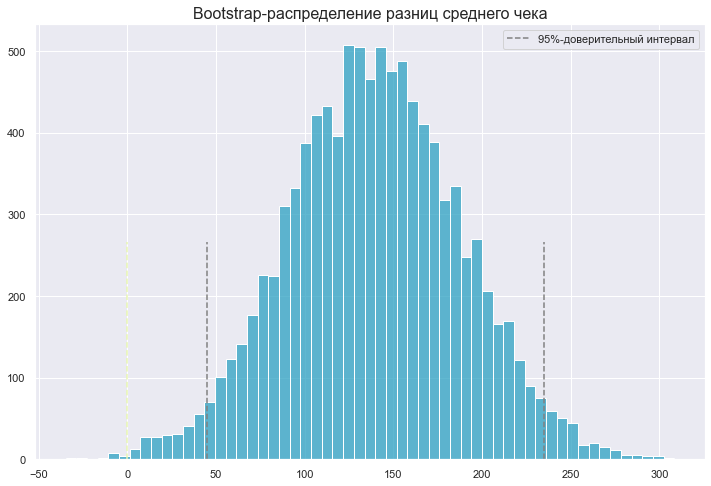

In [26]:
bootstrap_func(test, control)

__Вывод:__ результаты AB тестирования показывают, что начисление дополнительных 1000 баллов лояльности, позволило в среднем увеличить средний чек примерно на 140 руб

### Анализ по торговым точкам

Данные по точке 1178:

Размер тестовой группы: 2406
Размер контрольной группы: 2403
Средний чек в тестовой группе: 2936.386949293433
Средний чек в контрольной группе: 3036.214731585518
Разница средних чеков: -99.82778229208498


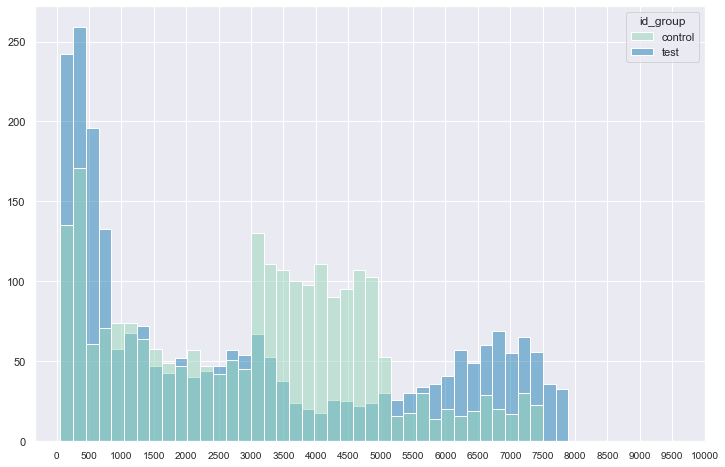

Принимается нулевая гипотеза
стат. критерий: -1.5338932633911708, pvalue: 0.1251217226713009
Распределения не равны
стат. критерий: 2659280.5, pvalue: 1.5133330174771163e-06
Bootstrap средняя разница среднего чека: -99.25155971162398


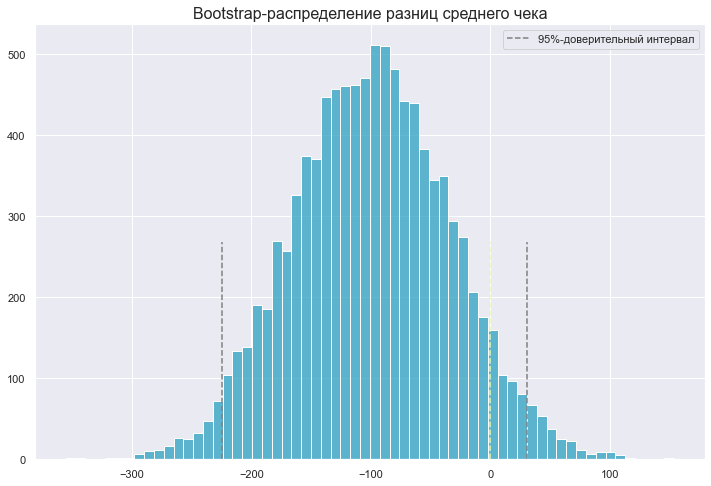


Данные по точке 1179:

Размер тестовой группы: 1745
Размер контрольной группы: 1697
Средний чек в тестовой группе: 3421.826934097421
Средний чек в контрольной группе: 3331.3105480259283
Разница средних чеков: 90.51638607149289


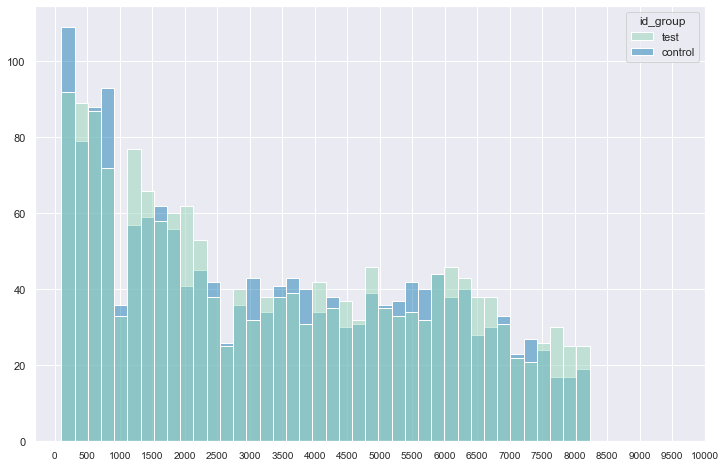

Принимается нулевая гипотеза
стат. критерий: 1.1225576641441302, pvalue: 0.2617037465196552
Распределения равны
стат. критерий: 1513598.5, pvalue: 0.2580763851815786
Bootstrap средняя разница среднего чека: 90.87232131058856


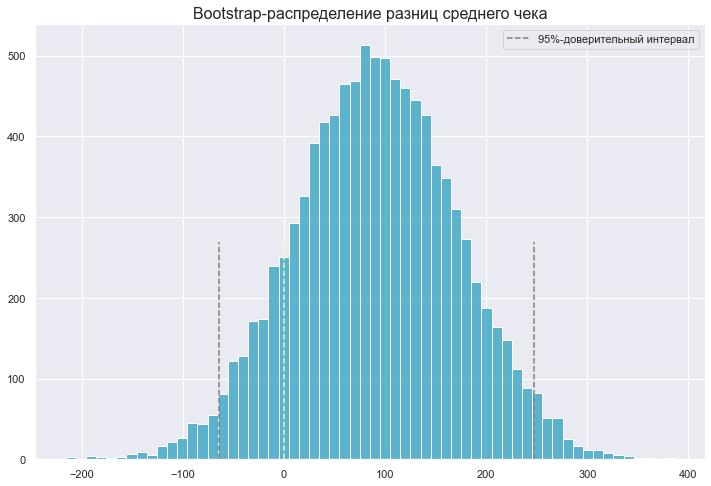


Данные по точке 1182:

Размер тестовой группы: 950
Размер контрольной группы: 1012
Средний чек в тестовой группе: 4945.12947368421
Средний чек в контрольной группе: 4036.9426877470355
Разница средних чеков: 908.1867859371746


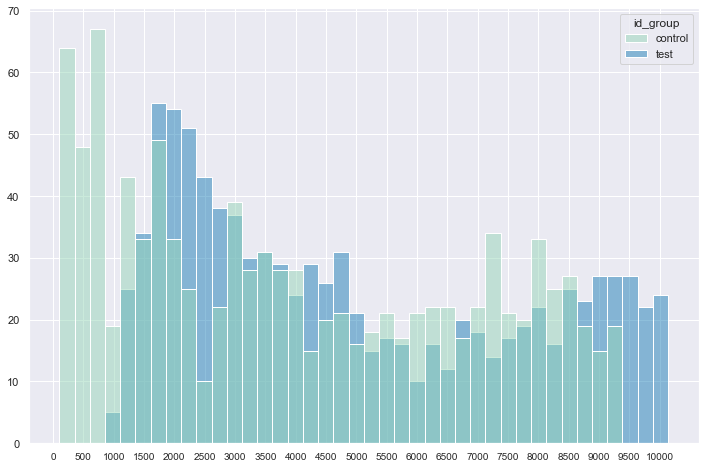

Принимается альтернативная гипотеза
стат. критерий: 7.172588995409098, pvalue: 1.0387447468996453e-12
Распределения не равны
стат. критерий: 578581.5, pvalue: 5.946812205351181e-15
Bootstrap средняя разница среднего чека: 909.1196644021219


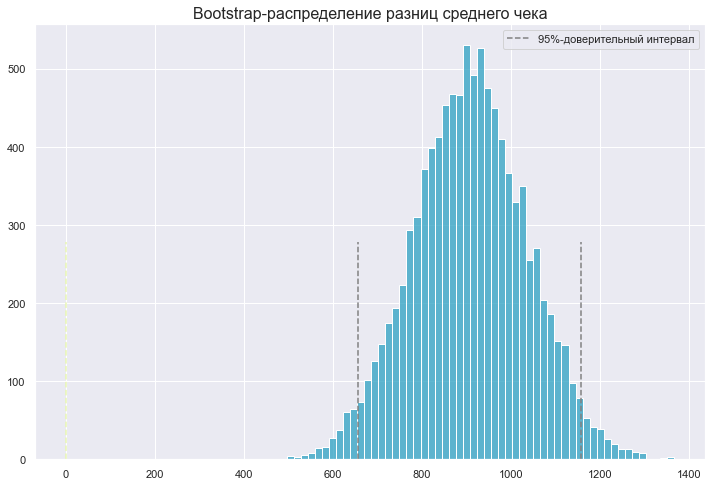


Данные по точке 1186:

Размер тестовой группы: 40
Размер контрольной группы: 23
недостаточно данных

Данные по точке 1188:

Размер тестовой группы: 4
Размер контрольной группы: 5
недостаточно данных



In [27]:
points = sorted(df['id_point'].unique())
for point in points:
    print(f'Данные по точке {point}:')
    print()
    df_point = df.copy()
    df_point = df_point[df_point['id_point'] == point]
    test = df_point[df_point['id_group'] == 'test']['sum_pay'].values
    control = df_point[df_point['id_group'] == 'control']['sum_pay'].values
    print(f'Размер тестовой группы: {len(test)}')
    print(f'Размер контрольной группы: {len(control)}')
    if min(len(test), len(control)) < 31:
        print('недостаточно данных')
        print()
        continue
    print(f'Средний чек в тестовой группе: {test.mean()}')
    print(f'Средний чек в контрольной группе: {control.mean()}')
    print(f'Разница средних чеков: {test.mean()-control.mean()}')
    show_hist(data=df_point,
              x=df['sum_pay'],
              hue="id_group")
    ttest_func(test, control)
    mann_whitney_func(test, control)
    bootstrap_func(test, control)
    print()

__Вывод:__ в разрезе торговых точек видно, что в точках 1178 и 1179 нет заметной положительной динамики по среднему чеку. В точке 1182 средняя разница средних чеков составила примерно 910 рублей, таким образом весь наблюдаемый на общих по всем точкам данных эффект обусловлен одной этой точкой продаж.
По точкам 1186, 1188 и 1199 недостаточно данных для анализа. Для того, чтобы сделать выводы, следует перезапустить тест и собрать достаточно данных по всем точкам.

### Сегментация по длительности регистрации

In [28]:
proxi_ranges(df['months_reg'], df['sum_pay'])

Дисперсия 1-го ряда: 10.153804438156643
Дисперсия 2-го ряда: 6141219.372748129
Ковариация: 4763.966628830186
Корреляция Пирсона: средняя
0.6032912239118214
Корреляция Спирмена: средняя
0.656391826962686


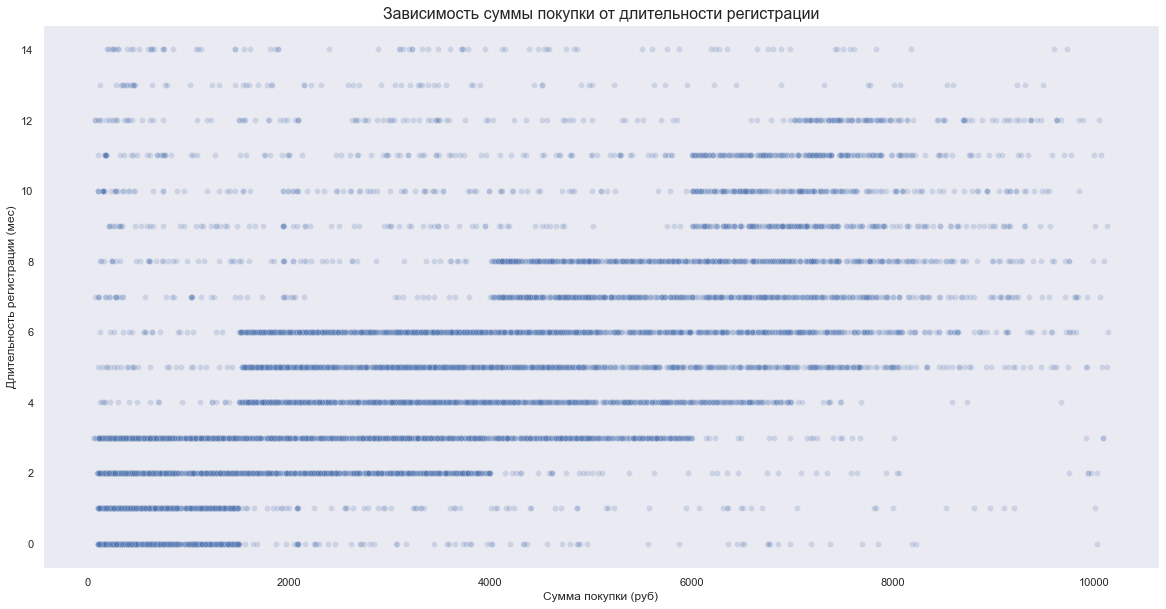

In [29]:
plt.figure(figsize=(20, 10))

plt.title("Зависимость суммы покупки от длительности регистрации", fontsize=16)
plt.xlabel("Сумма покупки (руб)")
plt.ylabel("Длительность регистрации (мес)")

plt.grid() 

sns.scatterplot(x=df['sum_pay'],
                y=df['months_reg'],
                alpha = 0.2);

In [30]:
df['sum_lower'] = (df['sum_pay'] // 1000) * 1000
df['sum_upper'] = (df['sum_pay'] // 1000 + 1) * 1000 - 1
df = df.astype({'sum_lower':'int','sum_upper':'int'}) #.astype({'sum_lower':'object','sum_upper':'object'})
df['sum_category'] = df['sum_lower'].apply(lambda x: str(x)) + '-' + df['sum_upper'].apply(lambda x: str(x))
df = df.sort_values('sum_lower').reset_index()
df

,index,id_client,id_group,sum_pay,id_point,months_reg,sum_lower,sum_upper,sum_category
0,5473,1359598,control,180.0,1178,12,0,999,0-999
1,6511,1362245,test,107.0,1178,3,0,999,0-999
2,6509,1363392,control,405.0,1178,2,0,999,0-999
3,6499,1373214,control,819.0,1179,2,0,999,0-999
4,6493,1363116,control,211.0,1178,0,0,999,0-999
...,...,...,...,...,...,...,...,...,...
10280,5571,1390123,test,10032.0,1182,0,10000,10999,10000-10999
10281,5448,1389690,test,10068.0,1182,11,10000,10999,10000-10999
10282,4420,1390562,test,10098.0,1182,8,10000,10999,10000-10999
10283,7229,1390203,test,10003.0,1182,11,10000,10999,10000-10999


In [31]:
reg_sum = df.groupby(['months_reg', 'sum_category']).agg({'id_client': 'count'}).reset_index()
reg_sum.rename(columns={'id_client': 'client_num'}, inplace=True)
reg_sum

,months_reg,sum_category,client_num
0,0,0-999,528
1,0,1000-1999,190
2,0,10000-10999,1
3,0,2000-2999,20
4,0,3000-3999,12
...,...,...,...
155,14,5000-5999,4
156,14,6000-6999,9
157,14,7000-7999,6
158,14,8000-8999,1


In [32]:
reg_sum_pivot = reg_sum.pivot(index="months_reg", 
                columns="sum_category", 
                values="client_num"
                                    )
reg_sum_pivot = reg_sum_pivot[['0-999', '1000-1999', '2000-2999', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999', '8000-8999', '9000-9999', '10000-10999']]
reg_sum_pivot.fillna(0, inplace=True)

In [33]:
col_list = reg_sum_pivot.columns

In [34]:
reg_sum_pivot1 = reg_sum_pivot.copy()
reg_sum_pivot1['sum'] = reg_sum_pivot1.sum(axis=1)
for col in col_list:
    reg_sum_pivot1[col] = reg_sum_pivot1[col] / reg_sum_pivot1['sum'] * 100
reg_sum_pivot1 = reg_sum_pivot1.iloc[:, :-1]

In [35]:
reg_sum_pivot2 = reg_sum_pivot.copy()
for col in col_list:
    reg_sum_pivot2[col] = reg_sum_pivot2[col] / sum(reg_sum_pivot2[col]) * 100

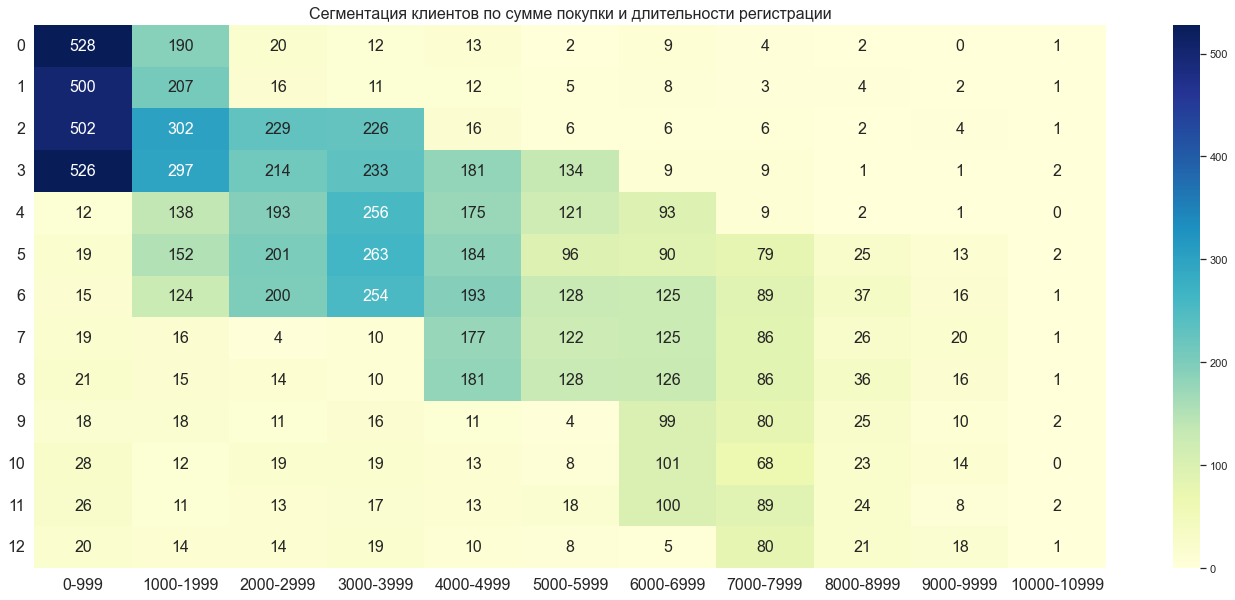

In [36]:
show_heatmap(data=reg_sum_pivot[:-2],
             title='Сегментация клиентов по сумме покупки и длительности регистрации',
             fmt='g')

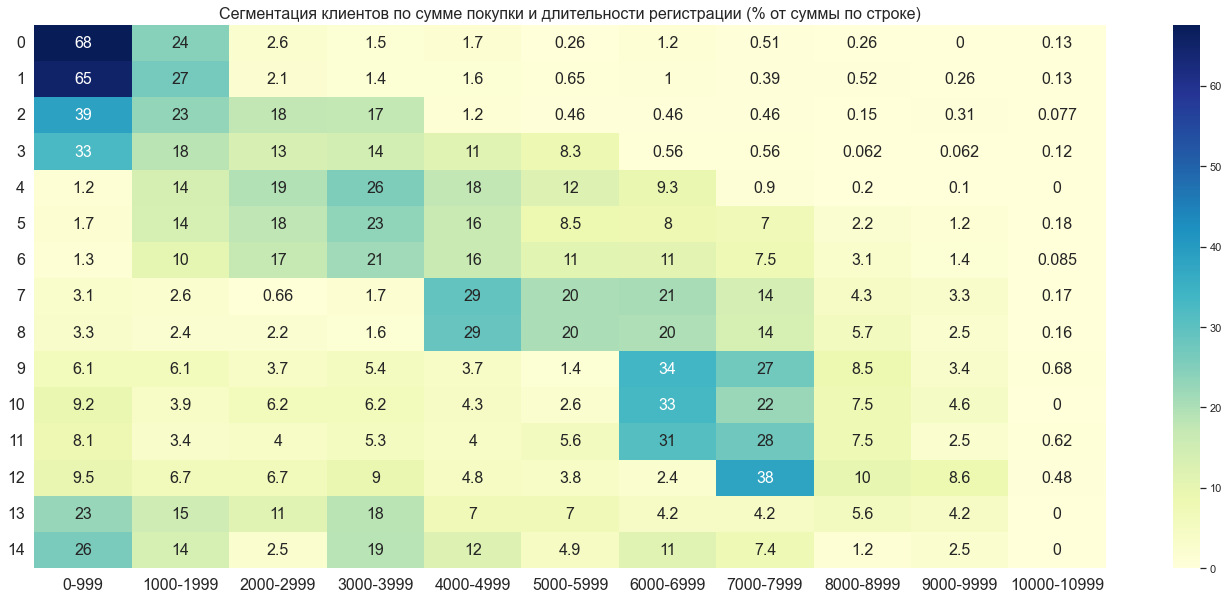

In [37]:
show_heatmap(data=reg_sum_pivot1,
             title='Сегментация клиентов по сумме покупки и длительности регистрации (% от суммы по строке)')

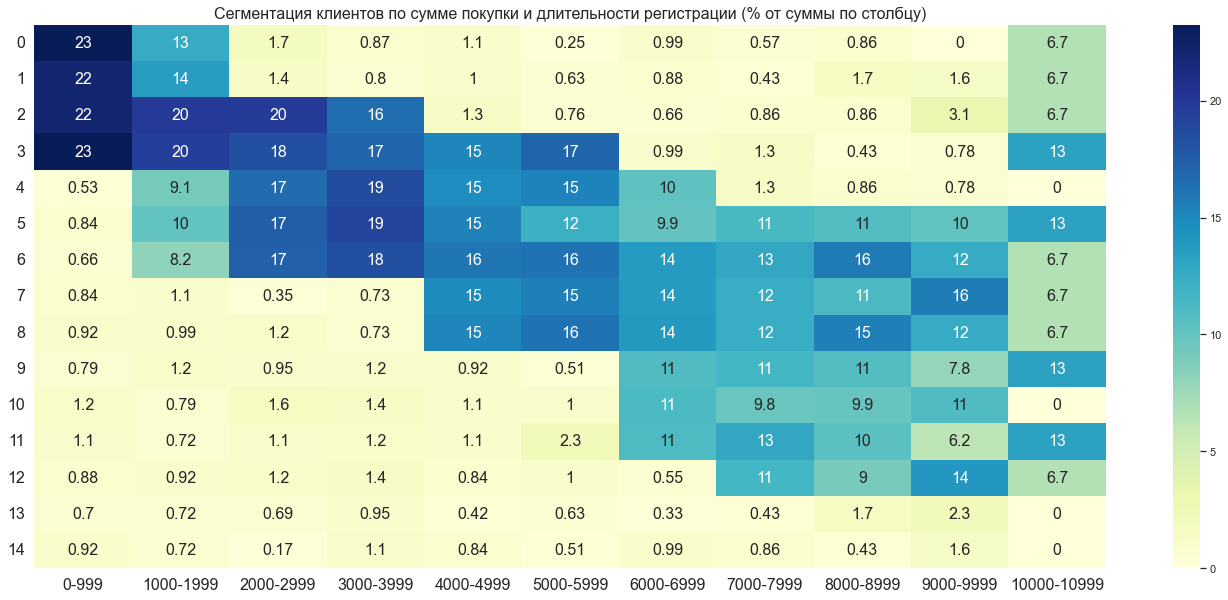

In [38]:
show_heatmap(data=reg_sum_pivot2,
             title='Сегментация клиентов по сумме покупки и длительности регистрации (% от суммы по столбцу)')